In [1]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 24  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

num_users_list = np.array([20])
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [3]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


    num_users  spawn_rate  payload_size        csv_filename
0          20          20             1        results_1_20
1          20          20             3        results_3_20
2          20          20             6        results_6_20
3          20          20            11       results_11_20
4          20          20            20       results_20_20
5          20          20            37       results_37_20
6          20          20            67       results_67_20
7          20          20           124      results_124_20
8          20          20           226      results_226_20
9          20          20           414      results_414_20
10         20          20           757      results_757_20
11         20          20          1384     results_1384_20
12         20          20          2528     results_2528_20
13         20          20          4620     results_4620_20
14         20          20          8442     results_8442_20
15         20          20         15425 

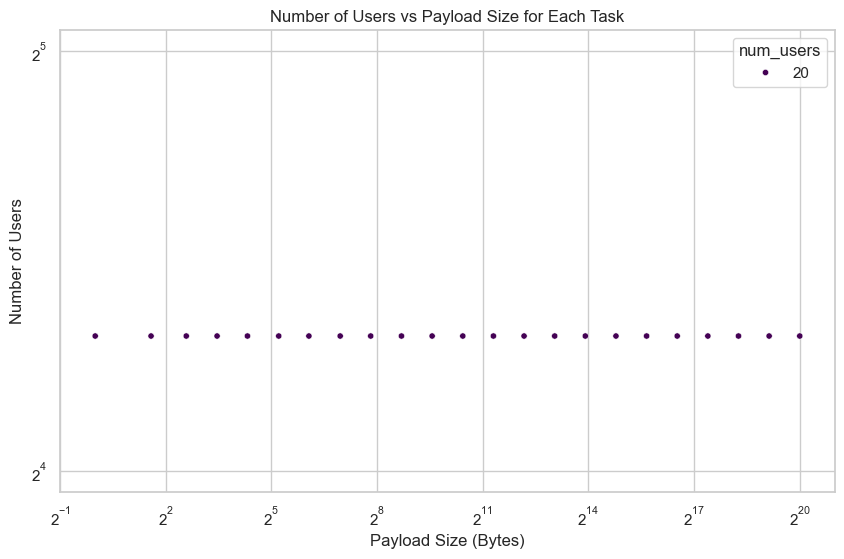

In [4]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [5]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [6]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 1, 'csv_filename': 'results_1_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 3, 'csv_filename': 'results_3_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 6, 'csv_filename': 'results_6_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 11, 'csv_filename': 'results_11_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 20, 'csv_filename': 'results_20_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 37, 'csv_filename': 'results_37_20'} as results already exist.
Skipping benchmark for task: {'num_users': 20, 'spawn_rate': 20, 'payload_size': 67, 'csv_filename': 'results_67_20'} as results already exist

In [7]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         20           24528          24.320759   
1              3         20           24435          24.419486   
2              6         20           24512          24.339916   
3             11         20           24462          24.371789   
4             20         20           24508          24.324864   
5             37         20           24537          24.312314   
6             67         20           24415          24.435609   
7            124         20           24169          24.670716   
8            226         20           24409          24.442307   
9            414         20           24364          24.487273   
10           757         20           24291          24.557318   
11          1384         20           24096          24.741536   
12          2528         20           24015          24.839612   
13          4620         20           23911          24.953341   
14        

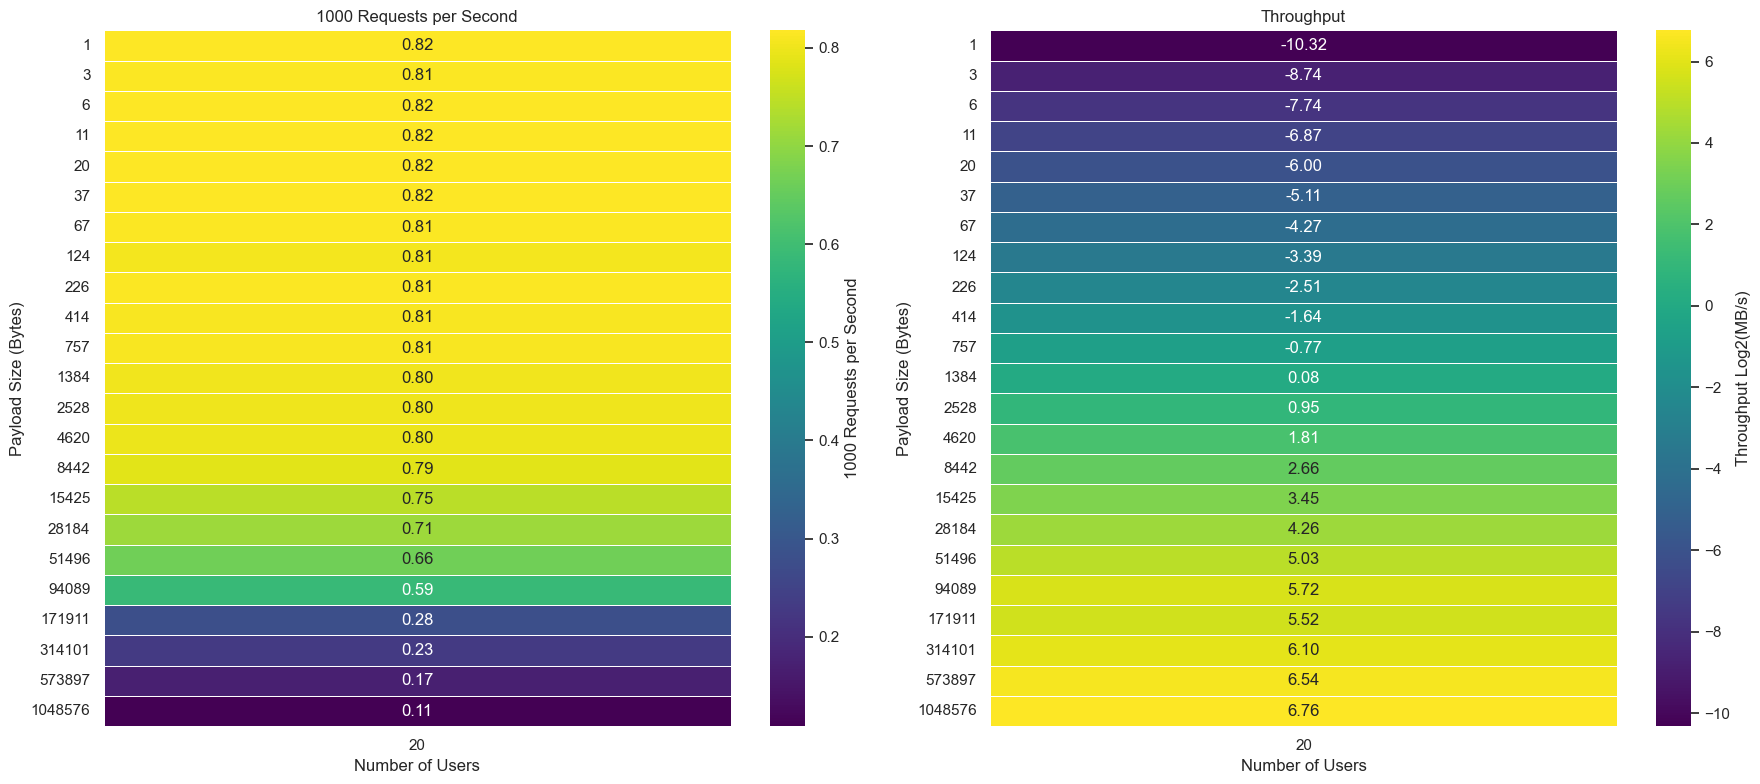

In [8]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

#results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']
results_df['med_response_time_per_user'] = results_df['med_response_time'] / results_df['num_users']
results_df['throughput'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size'] / 1024 / 1024 # MB/s

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="throughput")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second"}, ax=axes[0])
axes[0].set_title('1000 Requests per Second')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
log_heatmap_data = np.log2(heatmap_data_rt + 1e-6)
sns.heatmap(log_heatmap_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput Log2(MB/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [9]:
print( results_df['num_users'])

0     20
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
Name: num_users, dtype: int64


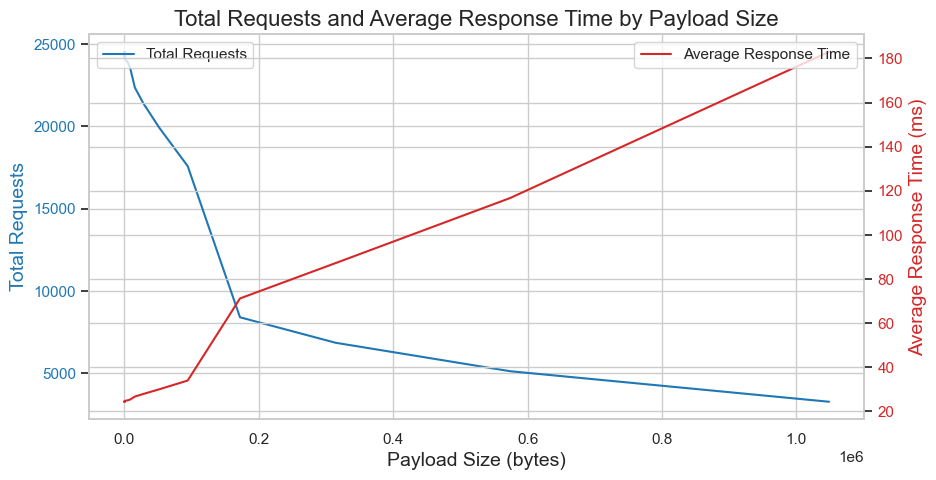

In [10]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()